In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

/home/admyyh/miniconda3/envs/ultralytics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [3]:
# Hyperparameters
batch_size = 128
epochs = 20
learning_rate = 1e-3
latent_dim = 20
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

In [4]:
# Data Loading
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(128 * 7 * 7, latent_dim)
        
        # Decoder input
        self.decoder_input = nn.Linear(latent_dim, 128 * 7 * 7)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 1, kernel_size=1),
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 128, 7, 7)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar
    
    def sample(self, num_samples):
        """
        Sample from the latent space and return generated images
        """
        z = torch.randn(num_samples, self.fc_mu.out_features).to(device)
        samples = self.decode(z)
        return samples

In [6]:
# Create model, optimizer
model = VAE(latent_dim).to(device)

In [7]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross entropy)
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE + KLD

In [8]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# Training loop
train_losses = []

# Training
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    avg_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')



Train Epoch: 1 [0/60000 (0%)]	Loss: 189.310654
Train Epoch: 1 [12800/60000 (21%)]	Loss: 42.687374
Train Epoch: 1 [25600/60000 (43%)]	Loss: 37.877510
Train Epoch: 1 [38400/60000 (64%)]	Loss: 38.092258
Train Epoch: 1 [51200/60000 (85%)]	Loss: 36.288918
====> Epoch: 1 Average loss: 42.1983
Train Epoch: 2 [0/60000 (0%)]	Loss: 35.030910
Train Epoch: 2 [12800/60000 (21%)]	Loss: 34.331436
Train Epoch: 2 [25600/60000 (43%)]	Loss: 33.537926
Train Epoch: 2 [38400/60000 (64%)]	Loss: 33.740112
Train Epoch: 2 [51200/60000 (85%)]	Loss: 33.617222
====> Epoch: 2 Average loss: 34.1849
Train Epoch: 3 [0/60000 (0%)]	Loss: 32.196171
Train Epoch: 3 [12800/60000 (21%)]	Loss: 33.103355
Train Epoch: 3 [25600/60000 (43%)]	Loss: 32.858696
Train Epoch: 3 [38400/60000 (64%)]	Loss: 32.503414
Train Epoch: 3 [51200/60000 (85%)]	Loss: 32.769608
====> Epoch: 3 Average loss: 32.6400
Train Epoch: 4 [0/60000 (0%)]	Loss: 31.330679
Train Epoch: 4 [12800/60000 (21%)]	Loss: 30.758804
Train Epoch: 4 [25600/60000 (43%)]	Loss: 

====> Test set loss: 29.0894


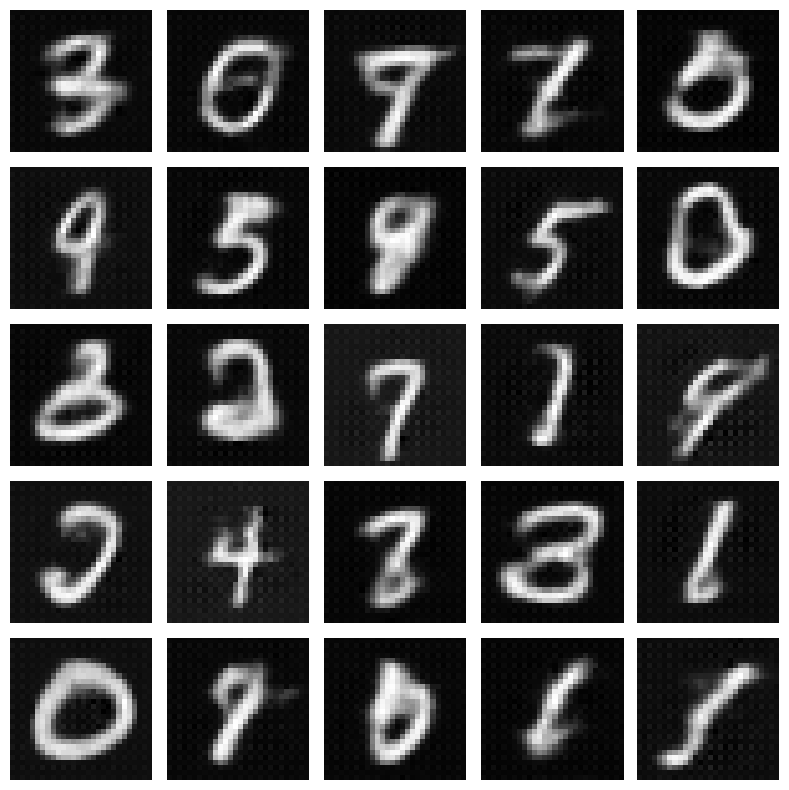

In [10]:
# Evaluation
model.eval()
test_loss = 0

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()

test_loss /= len(test_loader.dataset)
print(f'====> Test set loss: {test_loss:.4f}')

# Generate samples
with torch.no_grad():
    # Sample 25 images
    samples = model.sample(25).cpu()
    
    # Plot samples
    fig, axes = plt.subplots(5, 5, figsize=(8, 8))
    
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i][0], cmap='gray')
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('vae_mnist_samples.png')
    plt.show()

# Save the model
torch.save(model.state_dict(), 'vae_mnist.pth')